<a href="https://colab.research.google.com/github/lukeolson/imperial-multigrid/blob/master/lecture-3-amg-basics/18-components-of-smoothed-aggregation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# install pyamg if needed
!pip install pyamg

In [1]:
import numpy as np
import scipy.io as sio
import pyamg
import scipy.sparse.linalg as sla

import matplotlib.pyplot as plt
from matplotlib import collections
from matplotlib import tri
%matplotlib inline

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Read in a problem

This is a poisson problem on an unstructured mesh

`A` is the matrix

`vertices` are the vertices in the mesh

`elements` are the triangles in the mesh

In [2]:
data = pyamg.gallery.load_example('unit_square')

A = data['A'].tocsr()                        # matrix
V = data['vertices'][:A.shape[0]]            # vertices of each variable
Elmts = data['elements']
n = A.shape[0]

x = V[:,0]
y = V[:,1]

# Plot the mesh

(-1.7278759594743862,
 1.7278759594743862,
 -1.7278759594743862,
 1.7278759594743862)

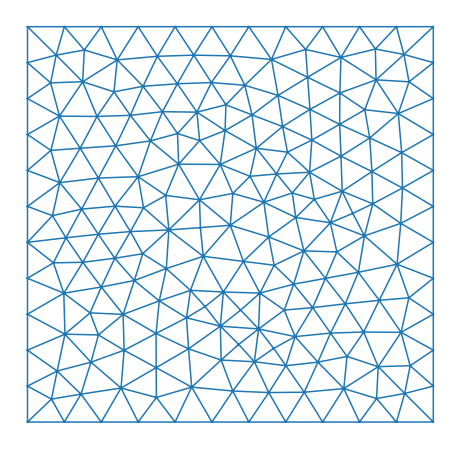

In [3]:
f, ax = plt.subplots(1, figsize=(8,8))
t = tri.Triangulation(x, y, Elmts)
plt.triplot(t)
plt.axis('off')

# Plot the "graph of $A$"

(-1.7278759594743864,
 1.7278759594743864,
 -1.727875959474386,
 1.7278759594743862)

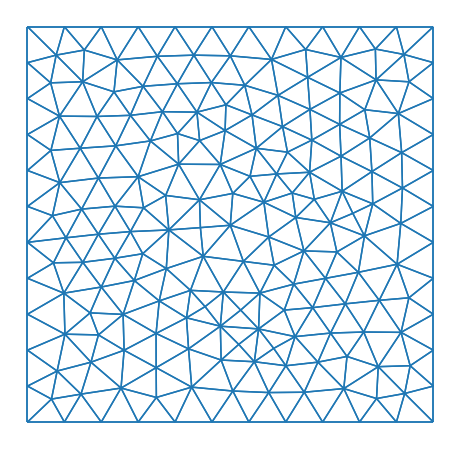

In [4]:
thismatrix = A
E = np.vstack((thismatrix.tocoo().row,thismatrix.tocoo().col)).T  # edges of the matrix graph

f, ax = plt.subplots(1, figsize=(8,8))

lines = np.empty((E.shape[0], 2, 2))
lines[:,0,0] = x[E[:,0]] # xstart
lines[:,1,0] = x[E[:,1]] # xend
lines[:,0,1] = y[E[:,0]] # ystart
lines[:,1,1] = y[E[:,1]] # yend

ls = collections.LineCollection(lines)
ax.add_collection(ls, autolim=True)
ax.autoscale_view()
ax.axis('off')

# Set the near null space or candidate vectors

In [5]:
B = np.ones((n,1))

# Find the strength of connection in the graph of $A$

In [6]:
S = pyamg.strength.symmetric_strength_of_connection(A, theta = 0.1)
S

<191x191 sparse matrix of type '<class 'numpy.float64'>'
	with 1139 stored elements in Compressed Sparse Row format>

In [7]:
def plotmatrix(thismatrix, ax, lw=1):
    E = np.vstack((thismatrix.tocoo().row,thismatrix.tocoo().col)).T  # edges of the matrix graph

    lines = np.empty((E.shape[0], 2, 2))
    lines[:,0,0] = x[E[:,0]] # xstart
    lines[:,1,0] = x[E[:,1]] # xend
    lines[:,0,1] = y[E[:,0]] # ystart
    lines[:,1,1] = y[E[:,1]] # yend

    ls = collections.LineCollection(lines)
    ax.add_collection(ls, autolim=True)
    ls.set_linewidth(lw)
    ax.autoscale_view()
    ax.axis('off')

  (0, 44)	3.5836987206849895
  (0, 135)	-0.1637016213373839
  (0, 136)	-0.2592866801893285
  (0, 145)	-0.33992670311949746
  (0, 149)	-0.5889002003064178
  (0, 175)	-0.7987400546279194
  (0, 177)	-0.9387324525423987
  (0, 178)	-0.49441100856204384


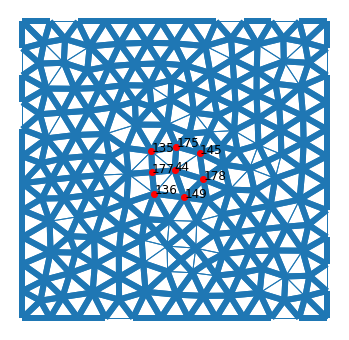

In [8]:
f, ax = plt.subplots(1, figsize=(6,6))

# FIRST A
plotmatrix(A, ax)

# THEN S
plotmatrix(S, ax, lw=6)

# What about point 44?
i = 44
J = A.getrow(i).indices
for j in J:
    plt.plot(x[j], y[j], 'ro')
    plt.text(x[j], y[j], '%d'%j, fontsize=12, color='k')
    
print(A.getrow(i))

# Aggregate based on Strength

In [9]:
AggOp, Cpts = pyamg.aggregation.aggregate.standard_aggregation(S)

In [10]:
AggOp

<191x28 sparse matrix of type '<class 'numpy.int8'>'
	with 191 stored elements in Compressed Sparse Row format>

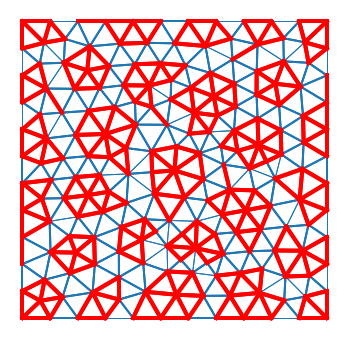

In [11]:
f, ax = plt.subplots(1, figsize=(6,6))

plotmatrix(A, ax)

plotmatrix(S, ax, lw=2)

# now plot each aggregate
for i in range(AggOp.shape[1]):
    J = AggOp.getcol(i).tocoo().row
    for j1 in J:
        for j2 in J:    
            if j1 != j2:
                if A[j1, j2]:
                    plt.plot([x[j1], x[j2]], [y[j1], y[j2]], 'r', lw=4)
                    
#for i, v in enumerate(V):
#    plt.text(v[0], v[1], '%d'%i)

# Create an interpolation operator

In [12]:
T, R = pyamg.aggregation.tentative.fit_candidates(AggOp, B)

In [13]:
T

<191x28 sparse matrix of type '<class 'numpy.float64'>'
	with 191 stored elements (blocksize = 1x1) in Block Sparse Row format>

# Improve the interpolation operator

In [14]:
P = pyamg.aggregation.smooth.jacobi_prolongation_smoother(A, T, S, B, degree=1).tocsr()

In [15]:
T = T.toarray()
P = P.toarray()

(-1.7278759594743862,
 1.7278759594743862,
 -1.7278759594743862,
 1.7278759594743862)

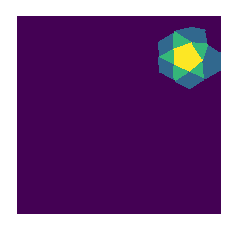

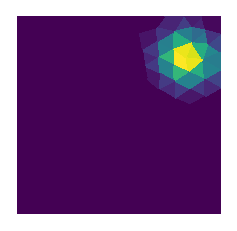

In [16]:
f, ax = plt.subplots(1, figsize=(4,4))
t = tri.Triangulation(x, y, Elmts)
plt.tripcolor(t, T[:,25])
plt.axis('off')

f, ax = plt.subplots(1, figsize=(4,4))
t = tri.Triangulation(x, y, Elmts)
plt.tripcolor(t, P[:,25])
plt.axis('off')

## A full multilevel hierarchy

In [17]:
ml = pyamg.smoothed_aggregation_solver(A, max_levels=2, keep=True, improve_candidates=None)
print(ml)

multilevel_solver
Number of Levels:     2
Operator Complexity:  1.187
Grid Complexity:      1.131
Coarse Solver:        'pinv2'
  level   unknowns     nonzeros
    0          191         1243 [84.21%]
    1           25          233 [15.79%]



In [18]:
res = []
b = np.zeros((n,))
x = np.random.rand(n)
x = ml.solve(b, x0=x, residuals=res)
print(res)

[14.959810153024476, 0.25225019888773564, 0.044717099870490225, 0.009680070350883717, 0.002267268215142334, 0.0005711889504957206, 0.0001540893951244343, 4.399309069173407e-05, 1.3092802260110403e-05, 4.007039004492956e-06]


In [19]:
res = np.array(res)
res[1:] / res[:-1]

array([0.01686186, 0.1772728 , 0.21647357, 0.23422022, 0.25192827,
       0.26976957, 0.28550369, 0.29761042, 0.306049  ])